In [1]:
pwd

'e:\\two_stage_model\\data_processing\\Speed_Processing'

In [2]:
cd ..

e:\two_stage_model\data_processing


In [49]:

import pandas as pd
import numpy as np
import geopandas as gpd
import networkx as nx
import pickle
import math

from datetime import datetime as dt
from tqdm import tqdm
from matplotlib import pyplot as plt
from copy import deepcopy
from scipy.stats import hmean

In [50]:
# Hyper-parameters during Data Processing 

# Time
start_date = dt(2022, 2, 14)
end_date = dt(2023, 2, 12)
start_min = 330 # 05:30:00 
end_min = 1260 # 21:00:00
country_name = 'TSMO'
model_path = 'E:/two_stage_model'

analysis_time_interval = 5 # in min
para_na_rate_spd_quantile_threshold_tmc_all = 1
busi_date = pd.bdate_range(start=start_date, end=end_date).date  # 260 business dates

## Part 1. Read Files

### 1.1 TMC Data
- Speed 
    - All (1431 TMC segments with geo-info and upstream segments, for TSMO)
    - PV (584 TMC segments with geo-info and upstream segments, for TSMO)
    - Truck (583 TMC segments with geo-info and upstream segments, for TSMO)

In [51]:
# TMC Speed Data 
# (1) All
df_spd_tmc_1min_all = pickle.load(open(f"{model_path}/data/{country_name}/tmc_speed_raw/{country_name}_df_downsampled_spd_tmc_1min_all.pkl", "rb"))  
df_spd_tmc_5min_all = pickle.load(open(f"{model_path}/data/{country_name}/tmc_speed_raw/{country_name}_df_downsampled_spd_tmc_5min_all.pkl", "rb"))  
# (2) Personal Vehicles
df_spd_tmc_5min_pv = pickle.load(open(f"{model_path}/data/{country_name}/tmc_speed_raw/{country_name}_df_downsampled_spd_tmc_5min_pv.pkl", "rb"))  
# (3) Trucks
df_spd_tmc_5min_truck = pickle.load(open(f"{model_path}/data/{country_name}/tmc_speed_raw/{country_name}_df_downsampled_spd_tmc_5min_truck.pkl", "rb"))  

In [52]:
df_spd_tmc_1min_all

tmc_code,110+04384,110+04385,110+04386,110+04387,110+04388,110+04389,110+04390,110+04409,110+04410,110+04411,...,110P55709,110P57062,110P57064,110P57066,110P57070,110P57072,110P57074,110P57076,110P57078,110P57082
measurement_tstamp,,,,,,,,,,,,,,,,,,,,,
2022-02-14 05:30:00,66.0,66.0,65.0,66.0,64.0,64.0,46.0,65.0,63.0,62.0,...,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02-14 05:31:00,66.0,63.0,65.0,66.0,64.0,64.0,45.0,65.0,65.0,63.0,...,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02-14 05:32:00,66.0,63.0,65.0,66.0,64.0,65.0,55.0,65.0,67.0,68.0,...,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02-14 05:33:00,66.0,65.0,65.0,66.0,63.0,65.0,55.0,66.0,67.0,68.0,...,52.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02-14 05:34:00,66.0,65.0,65.0,66.0,63.0,65.0,55.0,66.0,66.0,68.0,...,52.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-10 20:55:00,66.0,64.0,65.0,65.0,64.0,65.0,68.0,61.0,65.0,65.0,...,45.0,16.0,51.0,42.0,44.0,52.0,52.0,21.0,50.0,45.0
2023-02-10 20:56:00,66.0,66.0,63.0,66.0,65.0,65.0,67.0,64.0,62.0,63.0,...,45.0,16.0,47.0,42.0,44.0,52.0,52.0,21.0,50.0,44.0
2023-02-10 20:57:00,66.0,66.0,63.0,66.0,66.0,67.0,67.0,66.0,60.0,65.0,...,45.0,16.0,47.0,42.0,44.0,52.0,55.0,21.0,50.0,43.0


### 1.2 Geo Data
- Shapefile (used for visualization)

In [53]:
# Shape
gdf_tmc = gpd.read_file(f'{model_path}/data/{country_name}/geo_info/{country_name}_tmc_shape_for_sjoin.geojson')
gdf_tmc = gdf_tmc.rename(columns={"tmc":"id_tmc", "miles":"miles_tmc"})

In [54]:
# neighbour info
dict_prev_tmc = pickle.load(open(f"{model_path}/data/{country_name}/processed_data/{country_name}_dict_prev_tmc.pkl", "rb"))

In [55]:
gdf_tmc # for TMSO network, 1591 links totally

,id_tmc,miles_tmc,direction,type_x,type_y,road_order,roadname,roadnumber,county,state,zip,start_latitude,start_longitude,end_latitude,end_longitude,layer,path,geometry
0,110-12744,1.070253,SOUTHBOUND,P1.11,Feature,1.000,HARPERS FARM RD,NaN,HOWARD,MD,21044,39.23316,-76.89893,39.22154,-76.88850,intermediate_tmc_b&h,/Users/haowu/Desktop/Transportation Research/T...,"LINESTRING (-76.89893 39.23316, -76.89886 39.2..."
1,110-07787,0.932912,SOUTHBOUND,P1.11,Feature,1.000,HILTON PKY,NaN,BALTIMORE CITY,MD,21229,39.30835,-76.67249,39.29614,-76.67200,intermediate_tmc_b&h,/Users/haowu/Desktop/Transportation Research/T...,"LINESTRING (-76.67249 39.30835, -76.67262 39.3..."
2,110P11784,0.017700,WESTBOUND,P1.11,Feature,1.000,OLD FREDERICK RD,MD-99,HOWARD,MD,21042,39.30282,-76.82426,39.30281,-76.82459,intermediate_tmc_b&h,/Users/haowu/Desktop/Transportation Research/T...,"LINESTRING (-76.82426 39.30282, -76.82459 39.3..."
3,110N55331,0.041891,WESTBOUND,P1.11,Feature,1.000,EXECUTIVE PARK DR,NaN,HOWARD,MD,21045,39.23557,-76.81382,39.23547,-76.81459,intermediate_tmc_b&h,/Users/haowu/Desktop/Transportation Research/T...,"LINESTRING (-76.81382 39.23557, -76.81417 39.2..."
4,110N53871,0.010679,WESTBOUND,P1.11,Feature,1.000,OLD MONTGOMERY RD,NaN,HOWARD,MD,21045,39.20530,-76.82823,39.20541,-76.82837,intermediate_tmc_b&h,/Users/haowu/Desktop/Transportation Research/T...,"LINESTRING (-76.82823 39.20530, -76.82837 39.2..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1586,110N06173,0.161367,EASTBOUND,P1.11,Feature,18.000,SYKESVILLE RD,MD-32,CARROLL,MD,21784,39.38106,-76.96788,39.37879,-76.96844,intermediate_tmc_carroll,/Users/haowu/Desktop/Transportation Research/T...,"LINESTRING (-76.96788 39.38106, -76.96797 39.3..."
1587,110-06174,0.135356,EASTBOUND,P1.11,Feature,19.000,SYKESVILLE RD,MD-32,CARROLL,MD,21784,39.37879,-76.96844,39.37711,-76.96730,intermediate_tmc_carroll,/Users/haowu/Desktop/Transportation Research/T...,"LINESTRING (-76.96844 39.37879, -76.96845 39.3..."
1588,110N06174,0.048057,EASTBOUND,P1.11,Feature,19.001,SYKESVILLE RD,MD-32,CARROLL,MD,21784,39.37711,-76.96730,39.37663,-76.96665,intermediate_tmc_carroll,/Users/haowu/Desktop/Transportation Research/T...,"LINESTRING (-76.96730 39.37711, -76.96721 39.3..."
1589,110-06175,0.650225,EASTBOUND,P1.11,Feature,20.000,SYKESVILLE RD,MD-32,CARROLL,MD,21784,39.37663,-76.96665,39.36860,-76.96419,intermediate_tmc_carroll,/Users/haowu/Desktop/Transportation Research/T...,"LINESTRING (-76.96665 39.37663, -76.96653 39.3..."


## Part 2. Segment Selection for Input & Output

### 2.1 Imputation on Raw Speed

In [10]:
def space_mean(speed_list: list):
    filtered_data = np.array(speed_list)
    filtered_data = filtered_data[~np.isnan(filtered_data)]
    harmonic_mean = hmean(filtered_data)
    return harmonic_mean

In [15]:
# take a long time to run
# Aggregate 1-min TMC speed data of all vehicles to 5-min for imputation use, space mean was used here
df_spd_tmc_5min_all_from_1_min = df_spd_tmc_1min_all.resample("5 min").apply(lambda x:  space_mean(x))
df_spd_tmc_5min_all_from_1_min = df_spd_tmc_5min_all_from_1_min[pd.Index(df_spd_tmc_5min_all_from_1_min.index.date).isin(busi_date)]
df_spd_tmc_5min_all_from_1_min = df_spd_tmc_5min_all_from_1_min[(df_spd_tmc_5min_all_from_1_min.index.hour * 60 + df_spd_tmc_5min_all_from_1_min.index.minute >= start_min ) & (df_spd_tmc_5min_all_from_1_min.index.hour * 60 + df_spd_tmc_5min_all_from_1_min.index.minute < end_min)]  # 5-min frequency, (260 * 186, 1000), 177267 NaN

c:\Users\haowu\Anaconda3\envs\traffic\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\haowu\Anaconda3\envs\traffic\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [16]:
df_spd_tmc_5min_all_from_1_min

tmc_code,110+04384,110+04385,110+04386,110+04387,110+04388,110+04389,110+04390,110+04409,110+04410,110+04411,...,110P55709,110P57062,110P57064,110P57066,110P57070,110P57072,110P57074,110P57076,110P57078,110P57082
measurement_tstamp,,,,,,,,,,,,,,,,,,,,,
2022-02-14 05:30:00,66.000000,64.377590,65.000000,66.000000,63.596215,64.596273,50.757914,65.396341,65.565264,65.686022,...,46.198347,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02-14 05:35:00,67.191634,66.372406,67.785924,68.000000,63.000000,65.000000,53.174632,63.779120,62.000000,67.197640,...,52.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02-14 05:40:00,68.000000,64.909091,67.785924,68.000000,62.596154,65.000000,56.797153,62.050559,62.000000,65.590343,...,51.395349,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02-14 05:45:00,65.571826,62.981246,66.596386,68.000000,62.596154,65.000000,56.797153,60.750731,60.389610,65.396341,...,50.196850,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02-14 05:50:00,64.791391,57.589017,64.961899,67.197640,63.000000,66.000000,57.000000,60.946529,59.973316,66.159875,...,50.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-10 20:35:00,66.988059,66.899089,65.295401,63.327583,62.197452,64.383917,64.389956,59.589041,61.184211,63.390093,...,44.550309,16.0,48.196721,44.594595,41.394231,45.779221,42.972716,21.0,52.000000,43.000000
2023-02-10 20:40:00,67.390408,68.361045,64.339623,65.390111,65.000000,62.797428,64.178952,58.616080,60.184271,61.396104,...,46.394850,16.0,49.000000,44.000000,41.000000,45.000000,44.178082,21.0,52.000000,45.000000
2023-02-10 20:45:00,63.758997,60.106309,59.979656,62.754124,65.191376,66.365989,65.197568,61.350534,64.396285,65.578090,...,45.000000,16.0,50.538843,43.394495,41.000000,52.000000,52.595420,21.0,51.781151,44.196429


In [27]:
print('number of Nan, for 5 min data computed from 1min data', df_spd_tmc_5min_all_from_1_min.isna().sum().sum())
print('percentage of Nan, for 5 min data computed from 1min data', (df_spd_tmc_5min_all_from_1_min.isna().sum().sum()/df_spd_tmc_5min_all_from_1_min.size)*100, '%')

number of Nan, for 5 min data computed from 1min data 134994
percentage of Nan, for 5 min data computed from 1min data 0.1950691269011415 %


In [19]:
pickle.dump(df_spd_tmc_5min_all_from_1_min, open(f"{model_path}/data_processing/Speed_Processing/{country_name}_df_spd  

In [23]:
df_spd_tmc_5min_all

tmc_code,110+04384,110+04385,110+04386,110+04387,110+04388,110+04389,110+04390,110+04409,110+04410,110+04411,...,110P17638,110P17640,110P50442,110P54282,110P54286,110P54288,110P54292,110P54568,110P55646,110P55650
measurement_tstamp,,,,,,,,,,,,,,,,,,,,,
2022-02-14 05:30:00,84.0,70.0,70.0,69.0,64.0,65.0,60.0,56.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02-14 05:35:00,57.0,56.0,56.0,NaN,58.0,NaN,59.0,54.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02-14 05:40:00,61.0,NaN,57.0,57.0,55.0,54.0,53.0,63.0,58.0,60.0,...,NaN,NaN,NaN,54.0,52.0,NaN,NaN,NaN,NaN,NaN
2022-02-14 05:45:00,64.0,63.0,63.0,67.0,61.0,65.0,55.0,51.0,58.0,60.0,...,NaN,NaN,NaN,45.0,57.0,50.0,NaN,NaN,NaN,NaN
2022-02-14 05:50:00,62.0,60.0,59.0,64.0,64.0,64.0,59.0,60.0,68.0,71.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-10 20:35:00,67.0,63.0,59.0,67.0,64.0,65.0,62.0,55.0,62.0,65.0,...,22.0,NaN,NaN,53.0,49.0,46.0,44.0,8.0,NaN,NaN
2023-02-10 20:40:00,59.0,57.0,62.0,62.0,68.0,70.0,65.0,61.0,61.0,NaN,...,NaN,NaN,NaN,52.0,45.0,NaN,NaN,7.0,32.0,32.0
2023-02-10 20:45:00,69.0,64.0,67.0,63.0,61.0,65.0,65.0,54.0,65.0,67.0,...,NaN,NaN,NaN,54.0,45.0,40.0,36.0,NaN,NaN,NaN


## Part 3. Anylysis Difference between 1min Inputed Data and 5 min data

In [30]:
abs_difference_1min_5min_df = (df_spd_tmc_5min_all_from_1_min[list(df_spd_tmc_5min_all.columns)]-df_spd_tmc_5min_all).abs()

In [32]:
abs_difference_1min_5min_df

tmc_code,110+04384,110+04385,110+04386,110+04387,110+04388,110+04389,110+04390,110+04409,110+04410,110+04411,...,110P17638,110P17640,110P50442,110P54282,110P54286,110P54288,110P54292,110P54568,110P55646,110P55650
measurement_tstamp,,,,,,,,,,,,,,,,,,,,,
2022-02-14 05:30:00,18.000000,5.622410,5.000000,3.000000,0.403785,0.403727,9.242086,9.396341,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02-14 05:35:00,10.191634,10.372406,11.785924,NaN,5.000000,NaN,5.825368,9.779120,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-02-14 05:40:00,7.000000,NaN,10.785924,11.000000,7.596154,11.000000,3.797153,0.949441,4.000000,5.590343,...,NaN,NaN,NaN,0.000000,3.000000,NaN,NaN,NaN,NaN,NaN
2022-02-14 05:45:00,1.571826,0.018754,3.596386,1.000000,1.596154,0.000000,1.797153,9.750731,2.389610,5.396341,...,NaN,NaN,NaN,7.984905,8.000000,7.000000,NaN,NaN,NaN,NaN
2022-02-14 05:50:00,2.791391,2.410983,5.961899,3.197640,1.000000,2.000000,2.000000,0.946529,8.026684,4.840125,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-10 20:35:00,0.011941,3.899089,6.295401,3.672417,1.802548,0.616083,2.389956,4.589041,0.815789,1.609907,...,6.0,NaN,NaN,2.612872,1.000000,0.974991,7.789241,23.000000,NaN,NaN
2023-02-10 20:40:00,8.390408,11.361045,2.339623,3.390111,3.000000,7.202572,0.821048,2.383920,0.815729,NaN,...,NaN,NaN,NaN,2.055537,4.595142,NaN,NaN,21.127700,12.0,8.0
2023-02-10 20:45:00,5.241003,3.893691,7.020344,0.245876,4.191376,1.365989,0.197568,7.350534,0.603715,1.421910,...,NaN,NaN,NaN,1.255850,10.447471,5.168984,17.173770,NaN,NaN,NaN


In [38]:
abs_difference_mean = abs_difference_1min_5min_df.mean()
print(abs_difference_mean)
print('the overall abs difference mean is', abs_difference_1min_5min_df.stack().mean())

tmc_code
110+04384     3.610860
110+04385     4.085084
110+04386     3.954792
110+04387     3.726920
110+04388     3.309376
               ...    
110P54288     6.159529
110P54292     7.544714
110P54568    13.208101
110P55646     7.715651
110P55650     9.309704
Length: 584, dtype: float64
the overall abs difference mean is 5.667113157077516


## Part 4. Fill Nan with 85 Percentile Data (for 1min and 5min data)
- if there is in 1 min data, then fill with 1min data
- if not, fill with 85 percentile data

In [39]:
# round the data, replace 1 min data where 5 min data are available
df_spd_tmc_5min_all_from_1_min_filled = df_spd_tmc_5min_all_from_1_min.round(2)
df_spd_tmc_5min_all_from_1_min_filled = df_spd_tmc_5min_all.combine_first(df_spd_tmc_5min_all_from_1_min_filled)

In [41]:
# file Nan value with 85 percentile value of the road
for tmc in tqdm(df_spd_tmc_5min_all_from_1_min.columns):
    percentile_85 = df_spd_tmc_5min_all_from_1_min_filled[tmc].quantile(0.85)
    df_spd_tmc_5min_all_from_1_min_filled[tmc].fillna(value=percentile_85, inplace=True)

100%|██████████| 1431/1431 [00:01<00:00, 1021.58it/s]


In [43]:
# check if all Nan data was filled
print('number of Nan, for 5 min data computed from 1min data', df_spd_tmc_5min_all_from_1_min_filled.isna().sum().sum())
print('percentage of Nan, for 5 min data computed from 1min data', (df_spd_tmc_5min_all_from_1_min_filled.isna().sum().sum()/df_spd_tmc_5min_all_from_1_min_filled.size)*100, '%')

number of Nan, for 5 min data computed from 1min data 0
percentage of Nan, for 5 min data computed from 1min data 0.0 %


In [45]:
pickle.dump(df_spd_tmc_5min_all_from_1_min_filled, open(f"{model_path}/data/{country_name}/processed_data/{country_name}_df_spd_tmc_5min_all_from_1_min.pkl", "wb"))

In [59]:
df_spd_tmc_5min_all_from_1_min_filled

tmc_code,110+04384,110+04385,110+04386,110+04387,110+04388,110+04389,110+04390,110+04409,110+04410,110+04411,...,110P55709,110P57062,110P57064,110P57066,110P57070,110P57072,110P57074,110P57076,110P57078,110P57082
measurement_tstamp,,,,,,,,,,,,,,,,,,,,,
2022-02-14 05:30:00,84.0,70.00,70.0,69.0,64.0,65.0,60.0,56.0,65.57,65.69,...,46.20,16.0,50.36,50.80,48.00,49.52,49.59,21.19,52.00,47.00
2022-02-14 05:35:00,57.0,56.00,56.0,68.0,58.0,65.0,59.0,54.0,62.00,67.20,...,52.00,16.0,50.36,50.80,48.00,49.52,49.59,21.19,52.00,47.00
2022-02-14 05:40:00,61.0,64.91,57.0,57.0,55.0,54.0,53.0,63.0,58.00,60.00,...,51.40,16.0,50.36,50.80,48.00,49.52,49.59,21.19,52.00,47.00
2022-02-14 05:45:00,64.0,63.00,63.0,67.0,61.0,65.0,55.0,51.0,58.00,60.00,...,50.20,16.0,50.36,50.80,48.00,49.52,49.59,21.19,52.00,47.00
2022-02-14 05:50:00,62.0,60.00,59.0,64.0,64.0,64.0,59.0,60.0,68.00,71.00,...,50.00,16.0,50.36,50.80,48.00,49.52,49.59,21.19,52.00,47.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-10 20:35:00,67.0,63.00,59.0,67.0,64.0,65.0,62.0,55.0,62.00,65.00,...,44.55,16.0,48.20,44.59,41.39,45.78,42.97,21.00,52.00,43.00
2023-02-10 20:40:00,59.0,57.00,62.0,62.0,68.0,70.0,65.0,61.0,61.00,61.40,...,46.39,16.0,49.00,44.00,41.00,45.00,44.18,21.00,52.00,45.00
2023-02-10 20:45:00,69.0,64.00,67.0,63.0,61.0,65.0,65.0,54.0,65.00,67.00,...,45.00,16.0,50.54,43.39,41.00,52.00,52.60,21.00,51.78,44.20


In [60]:
# check for NaN rate of imputed 5-min speed data of 584 TMC segments
na_rate_spd_tmc_5min_all = df_spd_tmc_5min_all.isna().mean()
print(na_rate_spd_tmc_5min_all.describe(), na_rate_spd_tmc_5min_all.quantile(q=para_na_rate_spd_quantile_threshold_tmc_all))

count    584.000000
mean       0.306381
std        0.281286
min        0.000000
25%        0.030056
50%        0.247074
75%        0.518548
max        0.999793
dtype: float64 0.999793217535153


In [62]:
# 2. Impute 5-min TMC speed data of all vehicles with aggregated 5-min TMC speed data of all vehicles
count = 0
for tmc in tqdm(df_spd_tmc_5min_all.columns):
    # all TMC segments in df_spd_tmc_5min_all are covered in df_spd_tmc_5min_all_from_1_min
    if tmc not in df_spd_tmc_5min_all_from_1_min_filled.columns:
        count += 1
    else:
        df_spd_tmc_5min_all[tmc] = df_spd_tmc_5min_all[tmc].fillna(df_spd_tmc_5min_all_from_1_min_filled[tmc])

print('number of tmc segements whose speed comes from 1min data instead of 5 min data: ', count)

  0%|          | 0/584 [00:00<?, ?it/s]

100%|██████████| 584/584 [00:16<00:00, 35.19it/s] 

number of tmc segements whose speed comes from 1min data instead of 5 min data:  0


In [63]:
# check for NaN rate of imputed 5-min speed data of 584 TMC segments
na_rate_spd_tmc_5min_all = df_spd_tmc_5min_all.isna().mean()
print(na_rate_spd_tmc_5min_all.describe(), na_rate_spd_tmc_5min_all.quantile(q=para_na_rate_spd_quantile_threshold_tmc_all))

count    584.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
dtype: float64 0.0


## Part 5. Process PV and Truck Speed
**\[Observation\]**

Now the imputed 5-min speed data of 584 TMC segments has fairly low NaN rate among nearly all 584 segments. 

Therefore, we don't get rid of any TMC segments.

In [69]:
# 3. Impute 5-min TMC speed data internally (all, pv, truck)
df_spd_ratio_tmc_5min_pv_vs_all = df_spd_tmc_5min_pv.divide(df_spd_tmc_5min_all_from_1_min_filled[list(df_spd_tmc_5min_pv.columns)])
df_spd_ratio_tmc_5min_pv_vs_all[df_spd_ratio_tmc_5min_pv_vs_all == np.inf] = np.nan
df_spd_tmc_5min_pv = df_spd_tmc_5min_pv.fillna(df_spd_tmc_5min_all_from_1_min_filled[list(df_spd_tmc_5min_pv.columns)]*df_spd_ratio_tmc_5min_pv_vs_all.mean(axis=0))

df_spd_ratio_tmc_5min_truck_vs_all = df_spd_tmc_5min_truck.divide(df_spd_tmc_5min_all_from_1_min_filled[list(df_spd_tmc_5min_truck)])
df_spd_ratio_tmc_5min_truck_vs_all[df_spd_ratio_tmc_5min_truck_vs_all == np.inf] = np.nan
df_spd_tmc_5min_truck = df_spd_tmc_5min_truck.fillna(df_spd_tmc_5min_all_from_1_min_filled[list(df_spd_tmc_5min_truck)]*df_spd_ratio_tmc_5min_truck_vs_all.mean(axis=0))

In [70]:
print(df_spd_tmc_5min_pv.isna().mean().describe())
print(df_spd_tmc_5min_truck.isna().mean().describe())

count    584.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
dtype: float64
count    583.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
dtype: float64


In [71]:
pickle.dump(df_spd_tmc_5min_pv, open(f"{model_path}/data/{country_name}/processed_data/{country_name}_df_spd_tmc_5min_pv.pkl", "wb"))
pickle.dump(df_spd_tmc_5min_truck, open(f"{model_path}/data/{country_name}/processed_data/{country_name}_df_spd_tmc_5min_truck.pkl", "wb"))

## Part 6. Select TMC Segments (Not Used!!)

### Selection of TMC Segments

In [ ]:
# 583 Target TMC Segments, for TSMO
set_target_tmc = set(df_spd_tmc_5min_all.columns).intersection(set(df_spd_tmc_5min_pv.columns)).intersection(set(df_spd_tmc_5min_truck.columns)) # 583 target TMC segments, for TSMO
list_target_tmc = list(set_target_tmc)
gdf_tmc_1min = gdf_tmc[gdf_tmc['id_tmc'].isin(list(df_spd_tmc_5min_all_from_1_min.columns))]

<AxesSubplot: title={'center': 'Visualization of Eventually Selected Target TMC (blue, 583) Segments'}>

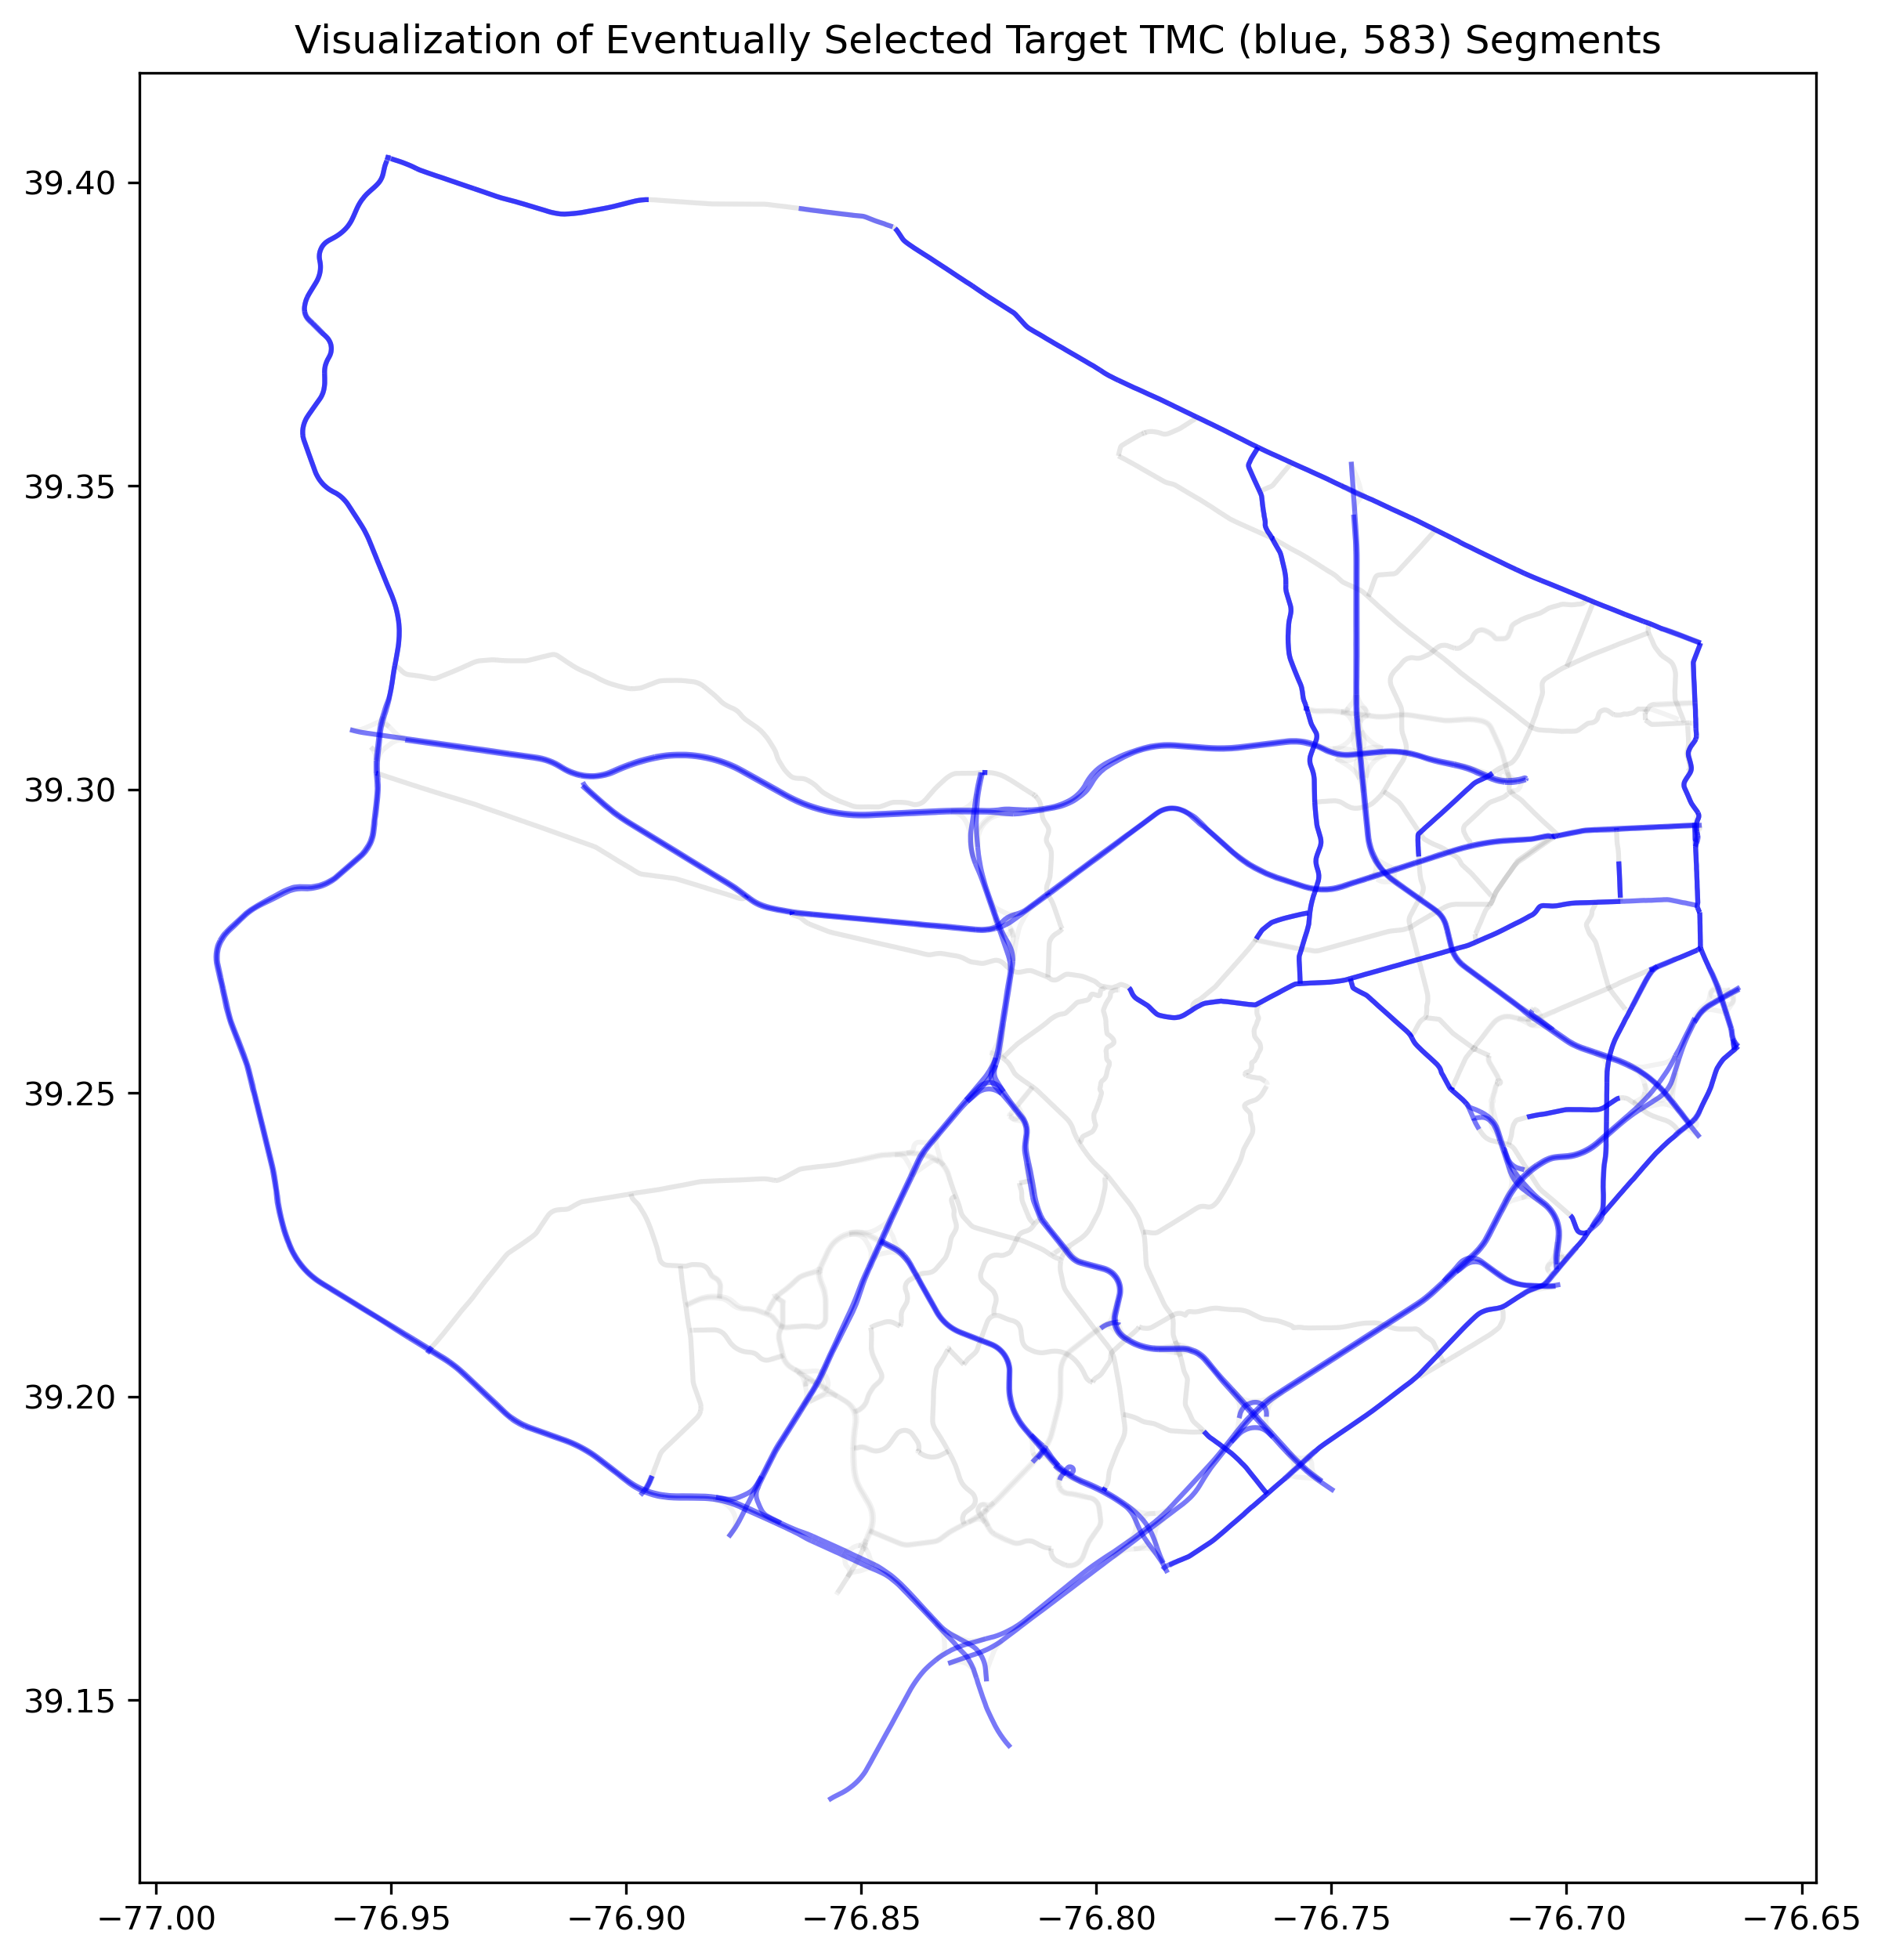

In [ ]:
fig, ax = plt.subplots(1,figsize=(15,10), dpi=300)
ax.set_title("Visualization of Eventually Selected Target TMC (blue, 583) Segments")
gdf_tmc_1min.plot(ax=ax, color="grey", alpha=0.1) # TMC segments that at least has one kind of speed data available in TSMO
gdf_tmc[gdf_tmc.id_tmc.isin(set_target_tmc)].plot(ax=ax, color="blue", alpha=0.5)  # 583 finalized TMC target segments, for TSMO

In [ ]:
df_spd_tmc_5min_all_selected = df_spd_tmc_5min_all[list_target_tmc]
df_spd_tmc_5min_pv_selected = df_spd_tmc_5min_pv[list_target_tmc]
df_spd_tmc_5min_truck_selected = df_spd_tmc_5min_truck[list_target_tmc]

In [ ]:
print(df_spd_tmc_5min_all_selected.shape)
print(df_spd_tmc_5min_pv_selected.shape)

(48360, 583)
(48360, 583)


In [ ]:
df_spd_tmc_5min_all_selected = df_spd_tmc_5min_all_selected.fillna(method='ffill')  # 755 NaN
df_spd_tmc_5min_pv_selected = df_spd_tmc_5min_pv_selected.fillna(method='ffill')  # 755 NaN
df_spd_tmc_5min_truck_selected = df_spd_tmc_5min_truck_selected.fillna(method='ffill')  # 755 NaN

df_spd_tmc_5min_all_selected = df_spd_tmc_5min_all_selected.fillna(method='bfill')  # 0 NaN
df_spd_tmc_5min_pv_selected = df_spd_tmc_5min_pv_selected.fillna(method='bfill')  # 0 NaN
df_spd_tmc_5min_truck_selected = df_spd_tmc_5min_truck_selected.fillna(method='bfill')  # 0 NaN

In [ ]:
df_spd_tmc_5min_all_selected

tmc_code,110N05245,110+12360,110N09555,110N12361,110+11763,110-05031,110-04419,110N04565,110-05036,110-12358,...,110P12746,110P04479,110-09558,110-05035,110N04408,110-12361,110-04388,110P55646,110N05034,110P17640
measurement_tstamp,,,,,,,,,,,,,,,,,,,,,
2022-02-14 05:30:00,74.0,39.0,24.0,36.0,21.0,44.0,69.0,56.0,26.6,54.4,...,28.0,31.2,51.0,37.8,63.0,37.0,69.0,62.2,47.2,38.0
2022-02-14 05:35:00,68.0,39.0,24.0,36.0,21.0,43.4,69.0,67.0,27.0,53.8,...,29.0,27.0,50.2,40.6,67.0,36.0,63.0,64.6,48.0,38.0
2022-02-14 05:40:00,70.0,37.0,28.6,31.0,21.4,43.0,69.0,66.0,28.0,53.0,...,29.4,23.0,35.0,40.0,62.0,33.0,67.0,65.0,48.0,38.0
2022-02-14 05:45:00,63.0,38.8,23.2,31.0,24.6,43.0,65.0,62.6,27.2,53.8,...,36.8,22.6,48.0,39.6,62.0,32.4,70.0,59.8,44.0,38.0
2022-02-14 05:50:00,64.0,35.0,35.0,31.0,13.0,48.0,67.0,65.0,32.2,52.8,...,38.4,22.0,18.0,41.6,64.0,33.0,70.0,56.4,13.0,38.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-10 20:35:00,65.0,29.0,27.2,34.0,31.0,24.2,62.0,60.8,45.0,48.6,...,10.0,24.8,38.0,25.0,63.0,30.0,69.6,44.4,30.6,47.0
2023-02-10 20:40:00,67.0,28.8,28.6,34.0,21.2,22.0,71.0,59.6,35.0,51.0,...,32.0,25.0,38.0,30.8,72.0,30.0,61.0,32.0,5.0,47.0
2023-02-10 20:45:00,65.0,28.0,29.0,33.0,21.2,40.0,66.0,69.0,52.0,50.8,...,33.2,18.0,38.0,35.0,56.0,32.0,64.0,44.6,37.0,47.0


In [ ]:
pickle.dump(df_spd_tmc_5min_all_selected, open(f"{model_path}/data/{country_name}/processed_data/{country_name}_df_spd_tmc_5min_all_selected.pkl", "wb"))